In [1]:
import datetime as dt
import itertools as it

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from recsys4daos.utils import notebooks as nbutils
from recsys4daos.model_selection import cvtt_open
import paths

sns.set_theme(rc = {
})
sns.set_context("paper")

# Paper column width in inches
PAPER_COL_WIDTH = 3.5

original = plt.rcParamsDefault['figure.figsize']
ratio = original[0] / original[1]
print(f"Original size: {original}, Ratio: {ratio}")
plt.rcParams['figure.figsize'] = (PAPER_COL_WIDTH, PAPER_COL_WIDTH/ratio)
print("New size:", plt.rcParams['figure.figsize'])

# In acmart, 9pt is the default
# And 7pt for \footnotesize
# plt.rcParams['font.size'] = 7,

# The following are already relatively defined
# plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']

Original size: [6.4, 4.8], Ratio: 1.3333333333333335
New size: [3.5, 2.6249999999999996]


/home/daviddavo/recsys4daos/src/recsys4daos/model_selection.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_FOLDS: int = 10
LAST_FOLD_DATE_STR: str = None # Used just for plotting

# Plotting hparams
RECTANGLE_ALPHA = 0.3

In [3]:
# Parameters
EXECUTION_ID = "2024-07-03"
ORG_NAME = "DAOSquare Grants"
SPLITS_FREQ = "W-FRI"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-07-02"


In [4]:
LAST_FOLD_DATE: dt.datetime = dt.datetime.fromisoformat(LAST_FOLD_DATE_STR) if LAST_FOLD_DATE_STR else dt.datetime.now()

In [5]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 880 non-null    object        
 1   author             880 non-null    object        
 2   date               880 non-null    datetime64[us]
 3   start              880 non-null    datetime64[us]
 4   end                739 non-null    datetime64[us]
 5   platform_proposal  880 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 41.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        702 non-null    object        
 1   proposal  702 non-null    object        
 2   voter     702 non-null    object        
 3   date      702 non-null    datetime64[us]
dtypes: dat

In [6]:
folds = list(cvtt_open(dfv, SPLITS_FREQ, dfp, normalize=SPLITS_NORMALIZE, col_item='proposal', col_time='date', last_fold=LAST_FOLD_DATE_STR))[-LAST_FOLDS:]
print(f"Using {len(folds)} folds from {folds[0].end} to {folds[-1].end}")

Using 5 folds from 2021-06-04 00:00:00 to 2021-07-02 00:00:00


## Proposals and time

### How much time does each proposal take

5 days 00:51:00    2
6 days 15:10:05    2
5 days 00:50:15    1
7 days 13:15:55    1
7 days 16:41:10    1
                  ..
9 days 10:25:25    1
9 days 10:27:20    1
9 days 10:24:25    1
9 days 10:23:25    1
7 days 01:54:40    1
Name: count, Length: 737, dtype: int64
5 days 00:51:00    0.002273
6 days 15:10:05    0.002273
5 days 00:50:15    0.001136
7 days 13:15:55    0.001136
7 days 16:41:10    0.001136
                     ...   
9 days 10:25:25    0.001136
9 days 10:27:20    0.001136
9 days 10:24:25    0.001136
9 days 10:23:25    0.001136
7 days 01:54:40    0.001136
Name: count, Length: 737, dtype: float64


count                       739
mean     7 days 16:09:57.155615
std      1 days 22:47:31.320083
min             5 days 00:06:25
25%             6 days 08:44:40
50%             7 days 03:32:10
75%             9 days 06:42:15
max            15 days 05:17:00
dtype: object

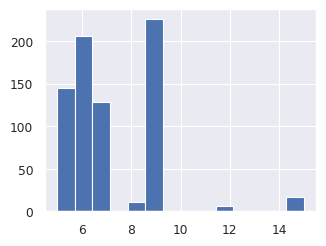

In [7]:
# Original: Cell [5] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb

delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
print(vc := delta.value_counts())
print(vc / len(delta))
delta.describe()

#### Avg. proposal length in time

In [8]:
def add_folds_to_plot(fig=plt, cont=True):

    if cont:
        start_date = folds[0].end
        end_date = folds[-1].end
        fig.axvspan(start_date, end_date, color='C2', alpha=RECTANGLE_ALPHA)
    else:
        for fprev, f, c in zip(folds, folds[1:], it.cycle([0,1])):
            start_date = fprev.end
            end_date = f.end
            fig.axvspan(start_date, end_date, alpha=RECTANGLE_ALPHA, color='C1' if c else 'C2')

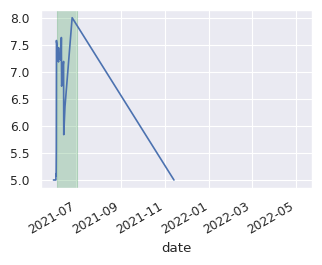

In [9]:
# Original: Cell [6] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
ROLLING_LENGTH = '7d'

_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling(ROLLING_LENGTH).mean().plot()

add_folds_to_plot()

## How many proposals are created per week

<Figure size 350x262.5 with 0 Axes>

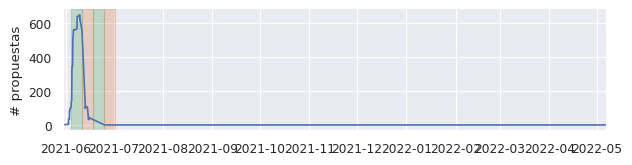

In [10]:
WINDOW_SIZE = dt.timedelta(days=7)

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

<Figure size 350x262.5 with 0 Axes>

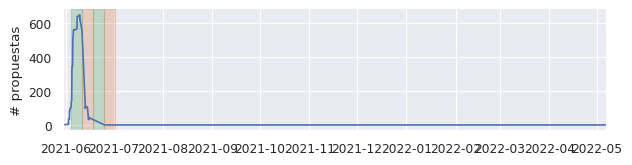

In [11]:
_toplot = _toplot[_toplot['date'] > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

## What day of the week are proposals created

start
Thursday     366
Sunday       215
Saturday      82
Friday        78
Wednesday     57
Tuesday       50
Monday        32
Name: count, dtype: int64


/tmp/ipykernel_1444436/3307774390.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

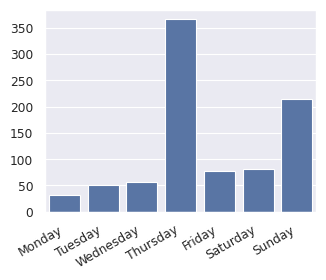

In [12]:
# Original: Cell [7] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
DAYS_OF_WEEK_ENG = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfp['start'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# proposals')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, 'proposals_dow.pdf')

## What day of the week are proposals voted

date
Friday       247
Saturday     223
Tuesday       79
Thursday      69
Wednesday     44
Monday        21
Sunday        19
Name: count, dtype: int64


/tmp/ipykernel_1444436/3643726510.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

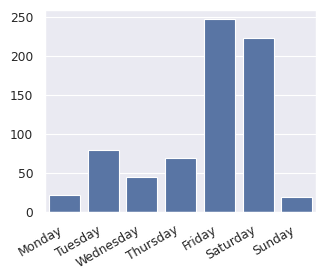

In [13]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfv['date'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# votes')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, "votes_dow.pdf")

## In which moment of the proposal lifetime are votes cast

time remaining                                              \
                          count      mean std       min       25%       50%   
delta                                                                         
5 days 00:06:25             1.0  0.999271 NaN  0.999271  0.999271  0.999271   
5 days 00:09:05             1.0  0.999491 NaN  0.999491  0.999491  0.999491   
5 days 00:17:50             1.0  0.999838 NaN  0.999838  0.999838  0.999838   
5 days 00:20:10             1.0  0.997692 NaN  0.997692  0.997692  0.997692   
5 days 00:26:00             1.0  0.997463 NaN  0.997463  0.997463  0.997463   
...                         ...       ...  ..       ...       ...       ...   
12 days 07:22:30            1.0  0.285240 NaN  0.285240  0.285240  0.285240   
12 days 10:35:10            1.0  0.281958 NaN  0.281958  0.281958  0.281958   
15 days 04:50:50            1.0  0.413975 NaN  0.413975  0.413975  0.413975   
15 days 04:54:45            1.0  0.413988 NaN  0.413988  0.413988  0.413988   
15 days 05:17:00            1.0  0.413674 NaN  0.413674  0.413674  0.413674   

                                      
                       75%       max  
delta                                 
5 days 00:06:25   0.999271  0.999271  
5 days 00:09:05   0.999491  0.999491  
5 days 00:17:50   0.999838  0.999838  
5 days 00:20:10   0.997692  0.997692  
5 days 00:26:00   0.997463  0.997463  
...                    ...       ...  
12 days 07:22:30  0.285240  0.285240  
12 days 10:35:10  0.281958  0.281958  
15 days 04:50:50  0.413975  0.413975  
15 days 04:54:45  0.413988  0.413988  
15 days 05:17:00  0.413674  0.413674  

[688 rows x 8 columns]

373 (53.13%) of the votes are being cast on the first 14.29% of rel time
702 (100.00%) of the votes are being cast on the first 85.71% of rel time


Cannot show ipywidgets in text

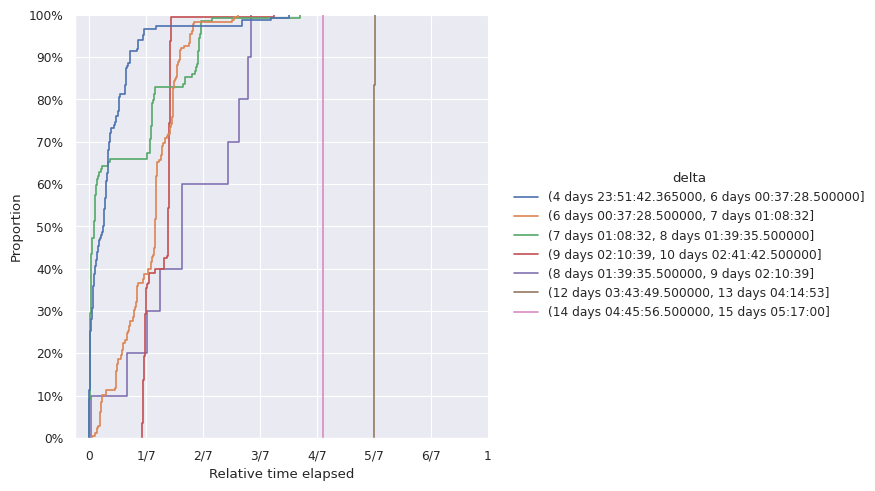

In [14]:
from matplotlib import ticker

PLOT_HUE = True
BINS = 10

_dfv = dfv[['proposal', 'date']].merge(dfp[['id', 'start', 'end']], left_on='proposal', right_on='id').sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
_dfv['delta'] = (_dfv['end'] - _dfv['start'])
_dfv['time remaining'] = 1 - _dfv['date_rel']

display(_dfv.groupby('delta')[['time remaining']].describe())

for t in [1/7, 6/7]:
    first_day = (_dfv['date_rel'] < t)
    print(f"{first_day.sum()} ({first_day.mean()*100:.2f}%) of the votes are being cast on the first {t*100:.2f}% of rel time")

if len(_dfv['delta'].value_counts()) > BINS:
    _dfv['delta_original'] = _dfv['delta']
    _dfv['delta'] = pd.cut(_dfv['delta'], BINS)

_dfv['delta'] = _dfv['delta'].astype(str)
fg = sns.displot(_dfv, x='date_rel', kind='ecdf', hue='delta' if PLOT_HUE else None)
# fg.ax.xaxis.set_major_locator(ticker.MultipleLocator(1/7))

fg.ax.yaxis.set_major_locator(ticker.MultipleLocator(1/10))
fg.ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
fg.ax.set_xticks(np.arange(8)/7)
fg.ax.set_xticklabels(["0"] + [f"{x}/7" for x in range(1,7)] + ["1"])
fg.ax.set_xlabel('Relative time elapsed');

nbutils.download_matplotlib(fg, f"votes_in_time{'-color' if PLOT_HUE else ''}.pdf")

## Explore folds

## Just used folds

In [15]:
for f in folds:
    print("="*10 + f"fold {f.end}" + 10*"=")
    print(len(f.open_proposals), "open proposals")
    print(f.train['voter'].nunique(), "users in train")
    print(f.test['voter'].nunique(), "users in train")
    print(len(np.intersect1d(f.test['voter'].unique(), f.test['voter'].unique())), "users in both")

==========fold 2021-06-04 00:00:00==========
413 open proposals
1 users in train
2 users in train
2 users in both
==========fold 2021-06-11 00:00:00==========
428 open proposals
2 users in train
2 users in train
2 users in both
==========fold 2021-06-18 00:00:00==========
30 open proposals
2 users in train
0 users in train
0 users in both
==========fold 2021-06-25 00:00:00==========
0 open proposals
2 users in train
0 users in train
0 users in both
==========fold 2021-07-02 00:00:00==========
1 open proposals
2 users in train
0 users in train
0 users in both


## Histograms

### Votes per user

count      2.000000
mean     351.000000
std      449.719913
min       33.000000
10%       96.600000
15%      128.400000
50%      351.000000
90%      605.400000
95%      637.200000
99%      662.640000
max      669.000000
dtype: float64
2 voters (100.00%) have voted more than 10 times
1 voters (50.00%) have voted more than 100 times


Cannot show ipywidgets in text

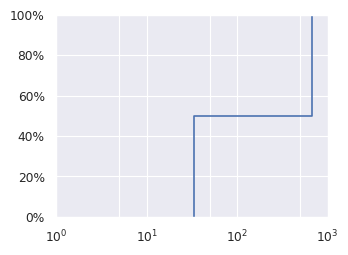

In [16]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print(_toplot.describe(percentiles=[.1, .15, .5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votes')
plt.ylabel('% voters')

_times_voted = [10, 100]
for t in _times_voted:
    _nusers = (_toplot > t).sum()
    print(f"{_nusers} voters ({_nusers/len(_toplot)*100:.2f}%) have voted more than {t} times")

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpv.pdf")

### Votes per proposal

count    690.000000
mean       1.017391
std        0.130819
min        1.000000
10%        1.000000
15%        1.000000
20%        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
90%        1.000000
95%        1.000000
99%        2.000000
max        2.000000
dtype: float64
Total votes: 702
0 proposals (0.00%) have more than 10 votes
0 proposals (0.00%) have more than 72 votes
0 proposals (0.00%) have more than 73 votes
0 proposals (0.00%) have more than 100 votes


Cannot show ipywidgets in text

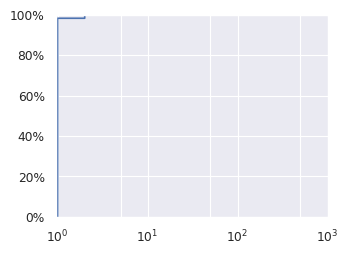

In [17]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.1, .15, .20, .25, .5,.75,.9, .95, .99]))

print("Total votes:", _toplot.sum())
_times_voted = [10, 72, 73, 100]
for t in _times_voted:
    _nprops = (_toplot > t).sum()
    print(f"{_nprops} proposals ({_nprops/len(_toplot)*100:.2f}%) have more than {t} votes")

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.xlabel('# votes')
plt.ylabel('% proposals')

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpp.pdf")